In [ ]:
import re
import string
import csv
import pickle
import requests
from io import StringIO

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# TensorFlow/Keras untuk deep learning
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, Conv1D, GlobalMaxPooling1D, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

# Scikit-learn untuk preprocessing, ekstraksi fitur, dan evaluasi
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Untuk modeling dan visualisasi
from gensim.models import Word2Vec
from wordcloud import WordCloud
from google_play_scraper import reviews_all

In [2]:
app_reviews_df = pd.read_csv('ulasan_aplikasi.csv')

In [3]:
app_reviews_df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,4b74bfac-51f2-47b2-bbd3-26a88dbba4ff,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Bagus sih bagus tapi drak sistemnya itu Lo moo...,5,0,1.9.64.10601,2025-04-12 18:14:35,NaN,NaN,1.9.64.10601
1,4f74ba66-b4aa-4f9c-b56e-5dc3f8d51a12,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,aku kasih bintang 1 karena aku main rank selal...,1,0,NaN,2025-04-12 18:14:21,NaN,NaN,NaN
2,dc2d668b-31b8-43ac-a655-f3d4ba7e00cb,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,solo player terlalu sering kena dark system d ...,1,0,19.2.21.104,2025-04-12 18:13:49,NaN,NaN,19.2.21.104
3,3fff788f-3e32-4115-b36e-d5d01917daa7,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,bagus banget sumpah,5,0,NaN,2025-04-12 18:13:14,NaN,NaN,NaN
4,338caa05-f805-4225-93a7-5f181e95a372,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,yg penting Heppy,3,0,1.9.64.10601,2025-04-12 18:12:49,NaN,NaN,1.9.64.10601


In [4]:
app_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243000 entries, 0 to 242999
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   reviewId              243000 non-null  object
 1   userName              243000 non-null  object
 2   userImage             243000 non-null  object
 3   content               242997 non-null  object
 4   score                 243000 non-null  int64 
 5   thumbsUpCount         243000 non-null  int64 
 6   reviewCreatedVersion  173484 non-null  object
 7   at                    243000 non-null  object
 8   replyContent          6147 non-null    object
 9   repliedAt             6147 non-null    object
 10  appVersion            173484 non-null  object
dtypes: int64(2), object(9)
memory usage: 20.4+ MB


In [5]:
# Menyimpan kolom content, score, userName, dan at
app_reviews_df = app_reviews_df[['userName', 'content', 'score', 'at']]
print(app_reviews_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243000 entries, 0 to 242999
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   userName  243000 non-null  object
 1   content   242997 non-null  object
 2   score     243000 non-null  int64 
 3   at        243000 non-null  object
dtypes: int64(1), object(3)
memory usage: 7.4+ MB
None


In [6]:
app_reviews_df.isnull().sum()

userName    0
content     3
score       0
at          0
dtype: int64

In [7]:
app_reviews_df.duplicated().sum()

7

In [8]:
clean_df = app_reviews_df.dropna()
clean_df = app_reviews_df.drop_duplicates()

In [9]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 242993 entries, 0 to 242999
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   userName  242993 non-null  object
 1   content   242990 non-null  object
 2   score     242993 non-null  int64 
 3   at        242993 non-null  object
dtypes: int64(1), object(3)
memory usage: 9.3+ MB


## Preprocessing Text

In [10]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
def cleaningText(text):
    # Pastikan text adalah string
    if not isinstance(text, str):
        text = str(text)
    text = re.sub(r'@[A-Za-z0-9]+', '', text)  # menghapus mention
    text = re.sub(r'#[A-Za-z0-9]+', '', text)  # menghapus hashtag
    text = re.sub(r'RT[\s]', '', text)          # menghapus "RT"
    text = re.sub(r"http\S+", '', text)          # menghapus link
    text = re.sub(r'[0-9]+', '', text)           # menghapus angka
    text = re.sub(r'[^\w\s]', '', text)          # menghapus karakter selain huruf dan angka
    text = text.replace('\n', ' ')               # mengganti baris baru dengan spasi
    text = text.translate(str.maketrans('', '', string.punctuation))  # hapus tanda baca
    text = text.strip()                          # hapus spasi di awal dan akhir
    return text
 
def casefoldingText(text): # Mengubah semua karakter dalam teks menjadi huruf kecil
    text = text.lower()
    return text
 
def tokenizingText(text): # Memecah atau membagi string, teks menjadi daftar token
    text = word_tokenize(text)
    return text
 
def filteringText(text): # Menghapus stopwords dalam teks
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy"])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text
 
def stemmingText(text): # Mengurangi kata ke bentuk dasarnya yang menghilangkan imbuhan awalan dan akhiran atau ke akar kata
    # Membuat objek stemmer
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
 
    # Memecah teks menjadi daftar kata
    words = text.split()
 
    # Menerapkan stemming pada setiap kata dalam daftar
    stemmed_words = [stemmer.stem(word) for word in words]
 
    # Menggabungkan kata-kata yang telah distem
    stemmed_text = ' '.join(stemmed_words)
 
    return stemmed_text
 
def toSentence(list_words): # Mengubah daftar kata menjadi kalimat
    sentence = ' '.join(word for word in list_words)
    return sentence

In [12]:
slangwords = {
    "@": "di", 
    "abis": "habis", 
    "wtb": "beli", 
    "masi": "masih", 
    "wts": "jual", 
    "wtt": "tukar", 
    "bgt": "banget", 
    "maks": "maksimal",
    "jgn": "jangan",       
    "gpp": "tidak apa apa", 
    "tdk": "tidak",         
    "bgmn": "bagaimana",   
    "btw": "ngomong",
    "mabar": "main bareng",
    "nt" : "apresiasi",
    "gg": "kerja bagus",
    "kelaz": "keren",
    "indomaret": "kalah retri dengan musuh",
    "darksistem": "player beban",
    "poke" : "lemah"

}
def fix_slangwords(text):
    words = text.split()
    fixed_words = []
 
    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)
 
    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [13]:
# Membersihkan teks dan menyimpannya di kolom 'text_clean'
clean_df['text_clean'] = clean_df['content'].apply(cleaningText)
 
# Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefoldingText'
clean_df['text_casefoldingText'] = clean_df['text_clean'].apply(casefoldingText)
    
# Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
clean_df['text_slangwords'] = clean_df['text_casefoldingText'].apply(fix_slangwords)
    
# Memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizingText'
clean_df['text_tokenizingText'] = clean_df['text_slangwords'].apply(tokenizingText)
 
# Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
clean_df['text_stopword'] = clean_df['text_tokenizingText'].apply(filteringText)
 
# Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
clean_df['text_akhir'] = clean_df['text_stopword'].apply(toSentence)

C:\Users\USER\AppData\Local\Temp\ipykernel_26656\3837347554.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['text_clean'] = clean_df['content'].apply(cleaningText)
C:\Users\USER\AppData\Local\Temp\ipykernel_26656\3837347554.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['text_casefoldingText'] = clean_df['text_clean'].apply(casefoldingText)
C:\Users\USER\AppData\Local\Temp\ipykernel_26656\3837347554.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

## Pelabelan

In [14]:

# Membaca data kamus kata-kata positif dari GitHub
lexicon_positive = dict()
 
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
# Mengirim permintaan HTTP untuk mendapatkan file CSV dari GitHub
 
if response.status_code == 200:
    # Jika permintaan berhasil
    reader = csv.reader(StringIO(response.text), delimiter=',')
    # Membaca teks respons sebagai file CSV menggunakan pembaca CSV dengan pemisah koma
 
    for row in reader:
        # Mengulangi setiap baris dalam file CSV
        lexicon_positive[row[0]] = int(row[1])
        # Menambahkan kata-kata positif dan skornya ke dalam kamus lexicon_positive
else:
    print("Failed to fetch positive lexicon data")
 
# Membaca data kamus kata-kata negatif dari GitHub
lexicon_negative = dict()
 
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')
# Mengirim permintaan HTTP untuk mendapatkan file CSV dari GitHub
 
if response.status_code == 200:
    # Jika permintaan berhasil
    reader = csv.reader(StringIO(response.text), delimiter=',')
    # Membaca teks respons sebagai file CSV menggunakan pembaca CSV dengan pemisah koma
 
    for row in reader:
        # Mengulangi setiap baris dalam file CSV
        lexicon_negative[row[0]] = int(row[1])
        # Menambahkan kata-kata negatif dan skornya dalam kamus lexicon_negative
else:
    print("Failed to fetch negative lexicon data")

In [15]:
# Fungsi untuk menentukan polaritas sentimen dari tweet
 
def sentiment_analysis_lexicon_indonesia(text):
    #for word in text:
 
    score = 0
    # Inisialisasi skor sentimen ke 0
 
    for word in text:
        # Mengulangi setiap kata dalam teks
 
        if (word in lexicon_positive):
            score = score + lexicon_positive[word]
            # Jika kata ada dalam kamus positif, tambahkan skornya ke skor sentimen
 
    for word in text:
        # Mengulangi setiap kata dalam teks (sekali lagi)
 
        if (word in lexicon_negative):
            score = score + lexicon_negative[word]
            # Jika kata ada dalam kamus negatif, kurangkan skornya dari skor sentimen
 
    polarity=''
    # Inisialisasi variabel polaritas
 
    if (score >= 0):
        polarity = 'positive'
        # Jika skor sentimen lebih besar atau sama dengan 0, maka polaritas adalah positif
    elif (score < 0):
        polarity = 'negative'
        # Jika skor sentimen kurang dari 0, maka polaritas adalah negatif
 
    # else:
    #     polarity = 'neutral'
    # Ini adalah bagian yang bisa digunakan untuk menentukan polaritas netral jika diperlukan
 
    return score, polarity
    # Mengembalikan skor sentimen dan polaritas teks

In [16]:
results = clean_df['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
clean_df['polarity_score'] = results[0]
clean_df['polarity'] = results[1]
print(clean_df['polarity'].value_counts())

polarity
positive    127143
negative    115850
Name: count, dtype: int64


C:\Users\USER\AppData\Local\Temp\ipykernel_26656\2380768602.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['polarity_score'] = results[0]
C:\Users\USER\AppData\Local\Temp\ipykernel_26656\2380768602.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['polarity'] = results[1]


In [17]:
!pip install wordcloud


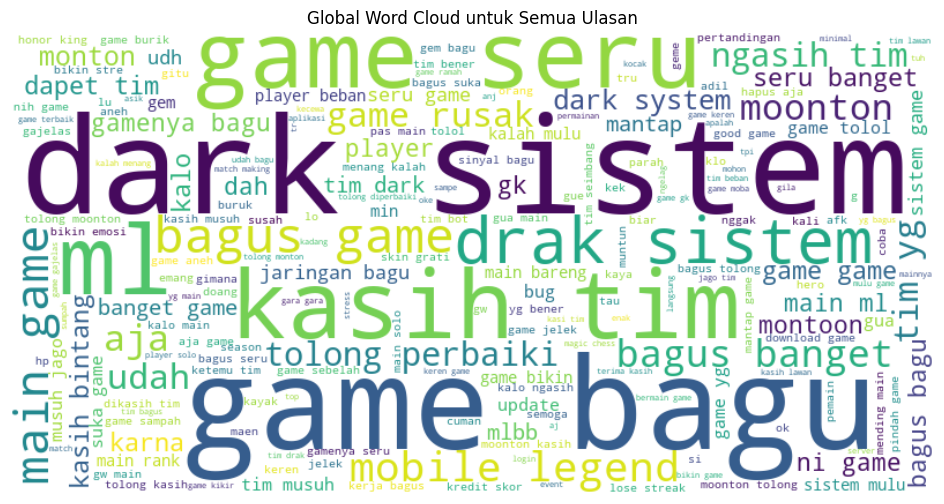

In [18]:
# Gabungkan seluruh teks ulasan (misalnya, kolom 'text_akhir' merupakan hasil akhir proses preprocessing)
global_text = ' '.join(clean_df['text_akhir'])

# Buat Word Cloud
global_wc = WordCloud(width=800, height=400, background_color='white').generate(global_text)

plt.figure(figsize=(12, 6))
plt.imshow(global_wc, interpolation='bilinear')
plt.axis('off')
plt.title("Global Word Cloud untuk Semua Ulasan")
plt.show()


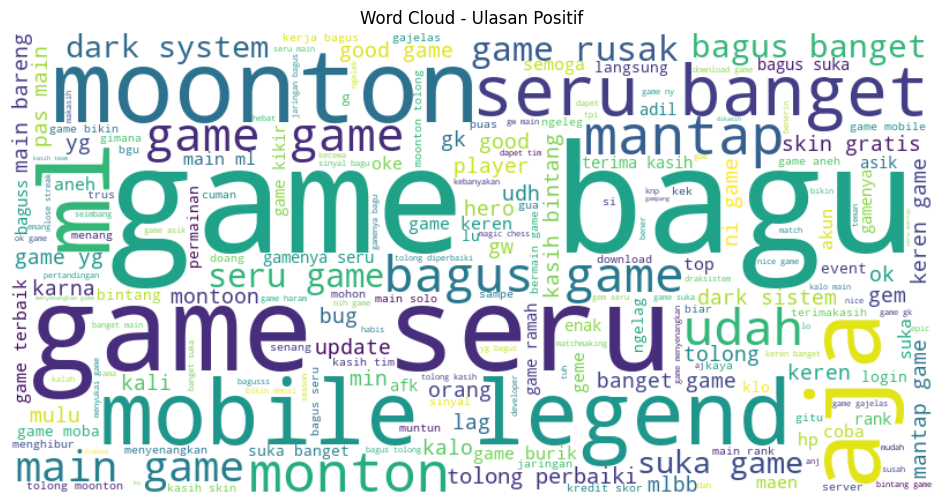

In [19]:
# Gabungkan teks ulasan untuk sentimen positif
positive_text = ' '.join(clean_df.loc[clean_df['polarity'] == 'positive', 'text_akhir'])

# Membuat dan menampilkan word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Ulasan Positif')
plt.show()


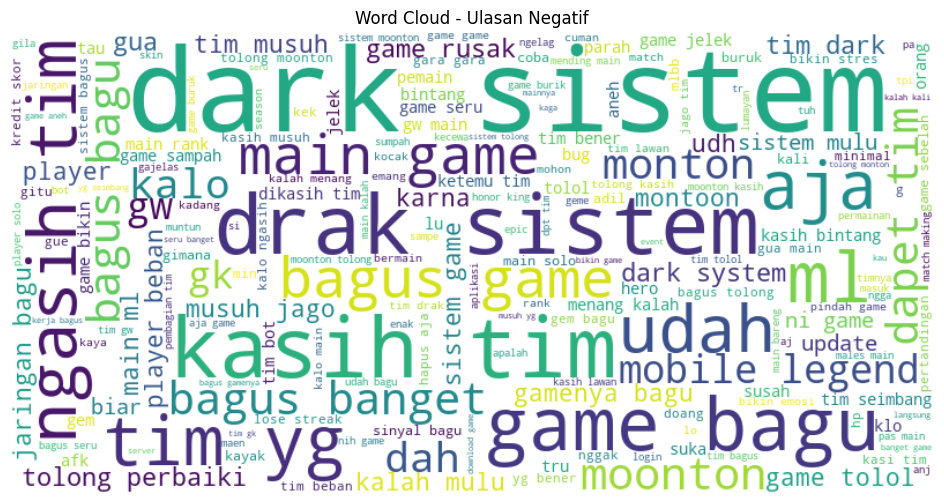

In [20]:
negative_text = ' '.join(clean_df.loc[clean_df['polarity'] == 'negative', 'text_akhir'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_text)
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Ulasan Negatif')
plt.show()



## 1. Global Word Cloud untuk Semua Ulasan

Pada **Global Word Cloud**, Anda menggabungkan *semua* ulasan (baik positif maupun negatif) dalam satu kumpulan teks. Oleh karena itu, kata-kata yang muncul adalah representasi umum dari keseluruhan pendapat pengguna. Beberapa kata yang terlihat menonjol:

- **“game”**: Menegaskan bahwa pembahasan para pengguna terfokus pada pengalaman gaming.  
- **“dark sistem”**: Muncul sebagai salah satu frasa utama. Di sini, istilah tersebut dipakai untuk menggambarkan pemain yang dianggap beban atau cupu, yang justru menghambat timnya.
- **“bagu” / “bagus” dan “seru”**: Kata-kata positif yang sering muncul, menggambarkan bahwa secara umum masih banyak ulasan yang menyatakan hal baik tentang game.
- **“kasih tim”** atau “tim”**: Menunjukkan bahwa topik tentang kerja sama tim, rekan setim, atau *matchmaking* sering disinggung.

Secara keseluruhan, **Global Word Cloud** memberikan gambaran makro mengenai topik yang paling banyak dibicarakan oleh pemain—mencakup kata bernuansa positif (misalnya, *seru, bagus*) dan negatif (misalnya, *dark, sistem*) dalam satu tampilan.


## 2. Word Cloud Ulasan Positif

Pada **Word Cloud Ulasan Positif**, hanya ulasan yang telah diklasifikasikan sebagai “positif” yang digunakan. Beberapa kata kunci yang dominan:

- **“game seru”, “bagus”, “mantap”**: Menunjukkan bahwa pengguna yang menyukai game ini banyak memuji *gameplay*, kualitas, dan *feature* game.  
- **“moonton”**: Nama developer yang sering disebut-sebut oleh pengguna, biasanya dikaitkan dengan pujian atau harapan untuk update.  
- **“mobile legend”**: Ini wajar karena nama lengkap game dibahas pengguna saat menyatakan pujian.  
- **“rusak”**: Sedikit janggal muncul dalam Word Cloud positif. Ada kemungkinan beberapa pengguna menulis kalimat seperti “walaupun kadang rusak, tetap seru,” atau “kerusakannya dikit aja, game tetap seru,” sehingga kata “rusak” masuk ke ulasan yang masih tergolong positif secara keseluruhan.

Dari visualisasi ini, bisa disimpulkan bahwa mayoritas ulasan positif menekankan keunggulan game ini, seperti tingkat keseruan, kualitas grafis, dan fitur yang disukai oleh pemain.


## 3. Word Cloud Ulasan Negatif

Berbeda dengan ulasan positif, **Word Cloud Ulasan Negatif** hanya terdiri dari ulasan yang dinilai negatif. Kata-kata yang banyak muncul, antara lain:

- **“dark sistem” / “drak sistem”**: Muncul sebagai salah satu frasa utama. Di sini, istilah tersebut dipakai untuk menggambarkan pemain yang dianggap beban atau cupu, yang justru menghambat timnya.  
- **“tim”**, “ngasih tim”, “kasih tim”**: Mengindikasikan banyak keluhan tentang rekan setim (kerja sama tim yang buruk) atau sistem tim yang tidak seimbang.  
- **“bagus”**: Kata “bagus” muncul di ulasan negatif mungkin dalam konteks “sebenarnya game ini bagus, tapi…,” yang menunjukkan ekspektasi pengguna terhadap game yang cukup tinggi namun merasa ada aspek tertentu yang mengecewakan.  
- **“udahgame”** atau frasa lain yang tampak tidak baku**: Mungkin adalah tulisan cepat pengguna di ulasan (typo, slang, atau kata sambung yang kurang jelas), tapi tetap memberi sinyal keluhan atau harapan untuk perbaikan.

Secara keseluruhan, pengguna yang memberikan ulasan negatif kerap mempermasalahkan sistem, tim, dan kinerja permainan—menandakan area-area inilah yang perlu diperhatikan oleh developer untuk meningkatkan kepuasan pemain.


## Ekstraksi Fitur

In [21]:
# Fitur ini akan digunakan untuk eksperimen LSTM dan Logistic Regression
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(clean_df['text_akhir'])
print("Dimensi fitur TF-IDF:", X_tfidf.shape)


Dimensi fitur TF-IDF: (242993, 5000)


In [22]:
# Tokenisasi sederhana untuk model Random F
clean_df['tokens'] = clean_df['text_akhir'].apply(lambda x: x.split())

# Latih model Word2Vec
w2v_model = Word2Vec(sentences=clean_df['tokens'], vector_size=100, window=5, min_count=2, workers=4, epochs=10)

def get_average_word2vec(tokens, model, vector_size=100):
    valid_words = [word for word in tokens if word in model.wv.key_to_index]
    if valid_words:
        return np.mean(model.wv[valid_words], axis=0)
    else:
        return np.zeros(vector_size)

X_w2v = np.vstack(clean_df['tokens'].apply(lambda tokens: get_average_word2vec(tokens, w2v_model)).values)
print("Dimensi fitur Word2Vec:", X_w2v.shape)


C:\Users\USER\AppData\Local\Temp\ipykernel_26656\664259465.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['tokens'] = clean_df['text_akhir'].apply(lambda x: x.split())


Dimensi fitur Word2Vec: (242993, 100)


In [23]:

# Encode label: negatif, netral, positif -> 0,1,2
le = LabelEncoder()
y = le.fit_transform(clean_df['polarity'])
print("Label mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

# Mencetak distribusi label
print(pd.Series(y).value_counts())

# Untuk eksperimen 1 dan 2 yang menggunakan TF-IDF:
# (Eksperimen 1: 70/30, Eksperimen 2: 80/20)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_tfidf, y, test_size=0.30, random_state=42)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_tfidf, y, test_size=0.20, random_state=42)

# Untuk eksperimen 3 yang menggunakan Word2Vec dengan split 75/25:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_w2v, y, test_size=0.25, random_state=42)


Label mapping: {'negative': 0, 'positive': 1}
1    127143
0    115850
Name: count, dtype: int64


### Eksperimen 1 LSTM + TF-IDF

In [24]:

# Parameter tokenisasi dan padding
max_features = 5000      # jumlah kata unik yang akan dipertimbangkan
maxlen = 150             # panjang sequence maksimal
embedding_dim = 100      # dimensi embedding

# Tokenize dan padding menggunakan kolom 'text_akhir' (hasil preprocessing)
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(clean_df['text_akhir'])
X_seq = tokenizer.texts_to_sequences(clean_df['text_akhir'])
X_seq = pad_sequences(X_seq, maxlen=maxlen)  # menghasilkan matriks dengan bentuk (n_samples, maxlen)

# Split data untuk eksperimen 1 (70/30)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_seq, y, test_size=0.30, random_state=42)

# One-hot encoding label untuk model LSTM
num_classes = len(le.classes_)
y_train_cat = to_categorical(y_train1, num_classes=num_classes)
y_test_cat = to_categorical(y_test1, num_classes=num_classes)


In [30]:

model_lstm = Sequential([
    # Embedding layer: mengubah input indeks kata menjadi vektor dense
    Embedding(input_dim=max_features, output_dim=embedding_dim, input_length=maxlen),
    
    # Bidirectional LSTM lapisan pertama dengan return_sequences=True agar bisa ditumpuk
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.5),
    
    # Bidirectional LSTM lapisan kedua
    Bidirectional(LSTM(32)),
    Dropout(0.5),
    
    # Dense layer untuk mengombinasikan fitur dan menghasilkan output klasifikasi
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model_lstm.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-3), metrics=['accuracy'])
model_lstm.summary()

# Menambahkan EarlyStopping untuk menghentikan pelatihan jika tidak ada peningkatan pada val_loss
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Melatih model LSTM dengan EarlyStopping
history_lstm = model_lstm.fit(X_train1, y_train_cat, 
                              epochs=3, 
                              batch_size=32, 
                              validation_data=(X_test1, y_test_cat),
                              callbacks=[early_stop])

# Evaluasi model LSTM
score_lstm = model_lstm.evaluate(X_test1, y_test_cat, verbose=0)
print("Eksperimen 1 - LSTM + Embedding, Testing Accuracy: {:.2f}%".format(score_lstm[1]*100))


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 150, 100)          500000    
                                                                 
 bidirectional_2 (Bidirectio  (None, 150, 128)         84480     
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 150, 128)          0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 64)               

### Eksperimen 2 KNN + TF-IDF

In [26]:
# Inisialisasi dan training model Logistic Regression
lr_model = LogisticRegression(random_state=42, solver='liblinear', max_iter=1000)
lr_model.fit(X_train2, y_train2)

# Prediksi dan evaluasi
y_pred_lr = lr_model.predict(X_test2)
acc_lr = accuracy_score(y_test2, y_pred_lr)
print("Eksperimen 2 - Logistic Regression + TF-IDF, Testing Accuracy: {:.2f}%".format(acc_lr*100))
print(classification_report(y_test2, y_pred_lr, target_names=le.classes_))

Eksperimen 2 - Logistic Regression + TF-IDF, Testing Accuracy: 96.20%
              precision    recall  f1-score   support

    negative       0.97      0.95      0.96     23184
    positive       0.95      0.98      0.96     25415

    accuracy                           0.96     48599
   macro avg       0.96      0.96      0.96     48599
weighted avg       0.96      0.96      0.96     48599



### Eksperimen 3 : Random Forest + Word2Vec

In [27]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train3, y_train3)
y_pred_rf = rf_model.predict(X_test3)
acc_rf = accuracy_score(y_test3, y_pred_rf)
print("Eksperimen 3 - Random Forest + Word2Vec, Testing Accuracy: {:.2f}%".format(acc_rf*100))
print(classification_report(y_test3, y_pred_rf, target_names=le.classes_))


Eksperimen 3 - Random Forest + Word2Vec, Testing Accuracy: 86.16%
              precision    recall  f1-score   support

    negative       0.84      0.88      0.86     28984
    positive       0.88      0.85      0.87     31765

    accuracy                           0.86     60749
   macro avg       0.86      0.86      0.86     60749
weighted avg       0.86      0.86      0.86     60749



In [ ]:
print("\n=== Perbandingan Akurasi Testing ===")
print("LSTM + Embedding + TF-IDF     : {:.3f}%".format(score_lstm[1]*100))
print("Logistic Regression + TF-IDF  : {:.3f}%".format(acc_lr*100))
print("Random Forest + Word2Vec      : {:.3f}%".format(acc_rf*100))


=== Perbandingan Akurasi Testing ===
LSTM + Embedding + TF-IDF     : 97.387%
Logistic Regression + TF-IDF  : 96.202%
Random Forest + Word2Vec      : 86.159%


: 


**Interpretasi dan Kesimpulan:**

1. **LSTM + Embedding + TF-IDF**  
   - Model ini menggunakan pendekatan deep learning dengan **Embedding Layer** untuk mengonversi setiap kata menjadi vektor dense dan **LSTM** (dengan mekanisme bidirectional) untuk menangkap urutan dan konteks kalimat.  
   - Penggunaan fitur TF-IDF (atau pengaruh dari preprocessing yang mengoptimalkan representasi teks) juga membantu model mendapatkan fitur yang kuat.  
   - Dengan akurasi sekitar 97.387%, model ini mampu menangkap nuansa linguistik dan konteks sentimen dari ulasan secara mendalam.  
   - Meskipun kompleks, keunggulan model ini terlihat ketika data ulasan memiliki keragaman ekspresi yang tinggi.

2. **Logistic Regression + TF-IDF**  
   - Model linier ini juga bekerja dengan representasi TF-IDF dan cukup cepat dilatih serta di-deploy.  
   - Performa yang hampir setara (96.202%) menandakan bahwa representasi TF-IDF sudah sangat representatif untuk dataset ini.  
   - Namun, model linier ini tidak secara eksplisit menangkap urutan kata atau konteks, sehingga jika ada teks yang kompleks, hal tersebut dapat berdampak pada interpretasi sentimen.

3. **Random Forest + Word2Vec**  
   - Model ini menggunakan representasi Word2Vec yang merata‐rata dari setiap ulasan, sehingga informasinya lebih “teragregasi” dan tidak secara eksplisit menangkap konteks sekuensial.  
   - Akurasi yang lebih rendah (86.159%) menunjukkan bahwa fitur Word2Vec dalam konfigurasi saat ini tidak dapat menangkap seluruh nuansa sentimen secara efektif untuk tugas ini.

**Kesimpulan :**

Kedua model berbasis TF-IDF (LSTM dan Logistic Regression) menunjukkan performa yang sangat kuat. Pemilihan antara keduanya bisa didasarkan pada pertimbangan seperti kompleksitas, kemampuan menangkap konteks sekuensial, dan kebutuhan computational resources. Model LSTM cenderung lebih unggul jika data ulasan panjang dan konteks urutan kata sangat penting, sedangkan Logistic Regression menawarkan kecepatan dan kesederhanaan implementasi.


### Inference dengan model LSTM

In [ ]:
# Misalnya sample_texts adalah data baru:
sample_texts = [
    "Game ini sangat menyenangkan dan grafisnya luar biasa!",
    "Saya kecewa dengan game ini, kontrolnya tidak responsif dan matchmaking buruk.",
    "Game rusak, kebanyakan player dark sistem!",
    "Saya senang memainkan game ini",
    "Saya kecewa dengan game ini, lemot dan matchmaking buruk."
]
# Preprocessing sederhana (lowercase, strip, dll)
preprocessed_texts = [text.lower().strip() for text in sample_texts]

# Ubah teks menjadi sequence token
sample_sequences = tokenizer.texts_to_sequences(preprocessed_texts)

# Padding sequence agar semua memiliki panjang maxlen (misalnya 150)
sample_sequences = pad_sequences(sample_sequences, maxlen=150)

# Lakukan prediksi dengan model LSTM
predictions = model_lstm.predict(sample_sequences)
predicted_classes = np.argmax(predictions, axis=1)

# Mapping sesuai label
label_mapping = {0: "negative", 1: "positive"}
predicted_labels = [label_mapping.get(c, "Unknown") for c in predicted_classes]

print("Input ulasan baru:")
for text in sample_texts:
    print(" -", text)

print("\nHasil Prediksi (kode kelas):", predictions)

print("Label Sentimen Prediksi:", predicted_labels)


1/1 [==============================] - 1s 955ms/step
Input ulasan baru:
 - Game ini sangat menyenangkan dan grafisnya luar biasa!
 - Saya kecewa dengan game ini, kontrolnya tidak responsif dan matchmaking buruk.
 - Game rusak, kebanyakan player dark sistem!
 - Saya senang memainkan game ini
 - Saya kecewa dengan game ini, lemot dan matchmaking buruk.

Hasil Prediksi (kode kelas): [[1.9188179e-04 9.9980813e-01]
 [9.8426950e-01 1.5730524e-02]
 [9.1441166e-01 8.5588306e-02]
 [2.0503702e-04 9.9979502e-01]
 [9.9860942e-01 1.3905453e-03]]
Label Sentimen Prediksi: ['positive', 'negative', 'negative', 'positive', 'negative']
